In [1]:
from LowLevelAnalysis import ConfigItem, ImageExtractorConfig, TailcutConfig, LowLevelAnalysis
from LowLevelData import Data, DL0Data, DL0DataSingleFile, DL1Data, DL1DataSingleFile

import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import math
from math import ceil
import numpy as np
import numpy.ma as ma
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
import tables
from collections import OrderedDict

import astropy.units as u
from astropy.io import fits
from astropy.table import Table, vstack

from traitlets.config.loader import Config
from ctapipe_io_lst import LSTEventSource
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
from ctapipe.image import hillas_parameters

from lstchain.io.config import read_configuration_file
import lstchain.reco.utils as utils
from lstchain.reco import r0_to_dl1
from lstchain.io.io import dl1_images_lstcam_key, dl1_params_tel_mon_ped_key, dl1_params_tel_mon_cal_key, dl1_params_lstcam_key, dl1_params_src_dep_lstcam_key

from ctapipe.utils import get_dataset_path
from ctapipe.io import EventSource
from ctapipe.io.eventseeker import EventSeeker
#import astropy.units as u
#from copy import deepcopy

from scipy.stats import binned_statistic



In [2]:
from logging import getLogger,StreamHandler,DEBUG,INFO,WARNING,ERROR,CRITICAL

##### Logger #####
logger = getLogger(__name__)
handler = StreamHandler()
loglevel = 'INFO'
handler.setLevel(loglevel)
logger.setLevel(loglevel)
logger.addHandler(handler)

In [3]:
from lstchain import __version__ as lstchain_version
logger.info(lstchain_version)

0.8.5.dev6+g50b0a41.d20220125


In [4]:
# Matplotlib setup
plt.rcParams["font.size"] = 13

LINE_STYLES = ["solid", "dashed", "dashdot", "dotted"]
MARKER_STYLES = ['o', 's', 'x', '+', 'D', 'X', 'p', 'd', '<', '>', '^', 'v', 'H']

#plt.xkcd()

In [5]:
# Replace OUTPUT_DIR_PATH by your directory
OUTPUT_DIR_PATH = Path('/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses')
if not OUTPUT_DIR_PATH.exists():
    os.makedirs(OUTPUT_DIR_PATH)


# Config of Tailcut

In [7]:
tailcut_config = TailcutConfig({"picture_thresh":6, "boundary_thresh":3, \
                                "sigma":2.5, "keep_isolated_pixels":"false", \
                                "min_number_picture_neighbors":2, \
                                "use_only_main_island":"false", \
                                "delta_time":2},
                              abbreviation='pth6_bth3')

# Config of ImageExtracter

## List of confugurations to evaluate  

In [8]:
image_extractor_configs = []
real_image_extractor_configs = []

# LocalPeakWindowSum
for window_width in (5,):
    window_shift = int(window_width/2)
    image_extractor_configs.append(ImageExtractorConfig('LocalPeakWindowSum', 
                                                        {'window_shift':window_shift,
                                                         'window_width':window_width,
                                                         'apply_integration_correction':'true'}
                                                       , abbreviation='LPWS'))
    real_image_extractor_configs.append(ImageExtractorConfig('LocalPeakWindowSum', 
                                                        {'window_shift':window_shift,
                                                         'window_width':window_width,
                                                         'apply_integration_correction':'false'}
                                                       , abbreviation='LPWS'))
    
# NeighborPeakWindowSum
for window_width in (5,):
    window_shift = int(window_width/2)
    for lwt in (0, ):#1):
        image_extractor_configs.append(ImageExtractorConfig('NeighborPeakWindowSum', 
                                                            {'window_shift':window_shift, 
                                                             'window_width':window_width,
                                                             'lwt':lwt,
                                                             'apply_integration_correction':'true'}
                                                       , abbreviation='NPWS'))
        real_image_extractor_configs.append(ImageExtractorConfig('NeighborPeakWindowSum', 
                                                            {'window_shift':window_shift, 
                                                             'window_width':window_width,
                                                             'lwt':lwt,
                                                             'apply_integration_correction':'false'}
                                                       , abbreviation='NPWS'))
        
# SlidingWindowMaxSum
for window_width in (5,):
    image_extractor_configs.append(ImageExtractorConfig('SlidingWindowMaxSum', 
                                                        {'window_width':window_width,
                                                         'apply_integration_correction':'true'}
                                                       , abbreviation='SWMS'))
    real_image_extractor_configs.append(ImageExtractorConfig('SlidingWindowMaxSum', 
                                                        {'window_width':window_width,
                                                         'apply_integration_correction':'false'}
                                                       , abbreviation='SWMS'))

# TwoPassWindowSum
for core_threshold in (6,):
    image_extractor_configs.append(ImageExtractorConfig('TwoPassWindowSum', 
                                                        {'core_threshold':core_threshold, 
                                                         'disable_second_pass':'false',
                                                         'apply_integration_correction':'true'}
                                                       , abbreviation='TPWS'))
    real_image_extractor_configs.append(ImageExtractorConfig('TwoPassWindowSum', 
                                                        {'core_threshold':core_threshold, 
                                                         'disable_second_pass':'false',
                                                         'apply_integration_correction':'false'}
                                                       , abbreviation='TPWS'))
    
# FullWaveformSum
#image_extractor_configs.append(ImageExtractorConfig('FullWaveformSum'
#                                                       , abbreviation='FWS'))

In [9]:
# Write the config files down     
lowlevel_configs= []
real_lowlevel_configs= []
for ie in image_extractor_configs:
    lowlevel_configs.append(LowLevelAnalysis(configs=[ie, tailcut_config], 
                                             output_dir_path=OUTPUT_DIR_PATH, 
                                             config_dir_path=OUTPUT_DIR_PATH,
                                            abbreviation=ie.abbreviation))
    real_lowlevel_configs.append(LowLevelAnalysis(configs=[ie, tailcut_config], 
                                             output_dir_path=OUTPUT_DIR_PATH, 
                                             config_dir_path=OUTPUT_DIR_PATH,
                                            abbreviation=ie.abbreviation))    
for c in lowlevel_configs:    
    c.write_configfile()
for c in real_lowlevel_configs:    
    c.write_configfile()    

# Shower event selection

In [10]:
EMIN = 0 *u.GeV
EMAX = 100 *u.GeV

In [11]:
tel_id = 1 #LST-1
allowed_tels = {tel_id}

In [12]:
HILLASES_OF_INTEREST = ['intensity', 
                        'log_intensity', 
                        'length', 
                        'width', 
                        'wl', 
                        'skewness',
                        'kurtosis', 
                        'leakage_intensity_width_2', 
                        #'dist',
                        'time_gradient']#, 'trigger_type', 'event_type']

# Real data

In [13]:
real_runs = [3948, 4699]
real_dates = {3948: '20210310', 4699: '20210511'}
real_subruns = {3948: range(0, 2), 4699: range(0, 2)}
calibration_runs = {3948:3945, 4699: 4696}
drs4_pedestal_runs = {3948: 3944, 4699: 4695}
time_calibration_runs = {3948: 3945, 4699: 4696}
analysis_version = {3948: 'v0.7.1', 4699: 'v0.7.3'}

# Real DL1 data

In [14]:
#dl1_data = tables.open_file('/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run04699.0000.h5')
#dl1_data.root#.dl1.event.telescope.image.LST_LSTCam)

In [15]:
#~/miniconda3/envs/lst-dev/bin/lstchain_create_drs4_pedestal_file --input /fefs/aswg/data/real/R0/20210511/LST-1.1.Run04695.0000.fits.fz --output ./drs4_pedestalRun04695.0000.h5 -m 5000

In [ ]:
%ls /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run04699.0005.h5

In [ ]:
script_path_str='/home/mitsunari.takahashi/Work/Soft/cta-lstchain/lstchain/scripts/lstchain_data_r0_to_dl1.py'

real_dl1_data_dict = {}

real_r0_paths = {}
calibration_paths = {}
drs4_pedestal_paths = {}
time_calibration_paths = {}
drive_log_paths = {}
run_summary_path = {}

drs4ped_dir_path = OUTPUT_DIR_PATH / 'real' / 'drs4_baseline'
if not drs4ped_dir_path.is_dir():
    drs4ped_dir_path.mkdir(parents=True) 
        
for run in real_runs:
    # Calibration file
    calibration_paths[run] = Path('/fefs/aswg/data/real/calibration/{date}/{ver}/calibration.Run{run:0>5.0f}.0000.hdf5'\
                                    .format(date=real_dates[run], ver=analysis_version[run], run=calibration_runs[run]))
    if not calibration_paths[run].is_file():
        logger.error('{0} does NOT exist!!'.format(calibration_paths[run]))
        break
    # DRS4 pedestal file
    drs4_pedestal_paths[run] = Path('{di}/drs4_pedestal.Run{run:0>5.0f}.0000.h5'\
                                      .format(di=drs4ped_dir_path, run=drs4_pedestal_runs[run]))
    if not drs4_pedestal_paths[run].is_file():
        command = ['lstchain_create_drs4_pedestal_file', 
                   '--input', '/fefs/aswg/data/real/R0/{date}/LST-{tel}.1.Run{run:0>5.0f}.0000.fits.fz'.format(date=real_dates[run], tel=tel_id, run=time_calibration_runs[run]), 
                   '--output', str(drs4_pedestal_paths[run])]
        logger.info(' '.join(command))
        subprocess.run(command)
            
    # Time calibration file
    time_calibration_paths[run] = Path('/fefs/aswg/data/real/calibration/{date}/{ver}/time_calibration.Run{run:0>5.0f}.0000.hdf5'\
                                      .format(date=real_dates[run], ver=analysis_version[run], run=time_calibration_runs[run]))
    if not time_calibration_paths[run].is_file():
        logger.error('{0} does NOT exist!!'.format(time_calibration_paths[run]))
        break  
    # Drive file
    drive_log_paths[run] = Path('/fefs/aswg/data/real/monitoring/DrivePositioning/drive_log_{yr}_{mon}_{day}.txt'\
                                .format(yr=real_dates[run][2:4], mon=real_dates[run][4:6], day=real_dates[run][6:8], ))
    if not drive_log_paths[run].is_file():
        logger.error('{0} does NOT exist!!'.format(drive_log_paths[run]))
        break   
    # Run summary (Reference Dragon counter)
    run_summary_path[run] = Path('/fefs/aswg/data/real/monitoring/RunSummary/RunSummary_{date}.ecsv'.format(date=real_dates[run]))
    if not run_summary_path[run].is_file():
        logger.error('{0} does NOT exist!!'.format(run_summary_path[run]))    

for lowlevel_config in real_lowlevel_configs:
    # Prepare directories
    out_dir_path = lowlevel_config.product_dir_path / 'real' / 'DL1'
    if not out_dir_path.is_dir():
        out_dir_path.mkdir(parents=True) 
        
    # Process R0 data  
    real_dl1_data_dict[lowlevel_config] = {}
    for run in real_runs:
        real_dl1_data_dict[lowlevel_config][run] = DL1Data(name='DL1 Real Run {0}'.format(run), datasrc='Real', 
                                                  hillas_parameters=HILLASES_OF_INTEREST, 
                                                  emin=EMIN, emax=EMAX, tel_id=tel_id)
        
            
        # R0 data file
        real_r0_paths[run] = []
        subrun_data_list = []
        for subrun in real_subruns[run]:
            real_r0_paths[run].append(Path('/fefs/aswg/data/real/R0/{date}/LST-1.1.Run{run:0>5.0f}.{subrun:0>4.0f}.fits.fz'\
                                      .format(date=real_dates[run],run=run, subrun=subrun)))
            if not real_r0_paths[run][-1].is_file():
                logger.error('{0} does NOT exist!!'.format(real_r0_paths[run][-1]))
                break    
                
            # R0 to DL1
            subrun_dl1_path = out_dir_path / 'dl1_LST-{tel}.Run{run:0>5.0f}.{subrun:0>4.0f}.h5'.format(tel=tel_id ,run=run, subrun=subrun)
            # Check
            %rm $subrun_dl1_path
            if subrun_dl1_path.is_file(): 
                logger.warning('{0} already exists!'.format(subrun_dl1_path))
                #continue
            else:    
                if not subrun_dl1_path.is_file():         
                    command = ['python', script_path_str,
                               '--input-file', '{r0_path}'.format(r0_path=real_r0_paths[run][-1]), 
                               '--config', '{config_path}'.format(config_path=lowlevel_config.config_path), 
                               '--output-dir', '{product_dir_path}'.format(product_dir_path=out_dir_path),
                               '--pedestal-file', '{drs4_pedestal_path}'.format(drs4_pedestal_path=drs4_pedestal_paths[run]),
                               '--calibration-file', '{calibration_path}'.format(calibration_path=calibration_paths[run]),
                               '--time-calibration-file', '{time_calibration_path}'.format(time_calibration_path=time_calibration_paths[run]),
                               '--pointing-file', '{pointing_path}'.format(pointing_path=drive_log_paths[run]), 
                               '--run-summary-path', '{runsummary}'.format(runsummary=run_summary_path[run]), 
                               #'--dragon-reference-time', '{}'.format(1620774291960678001)
                              ]
                    logger.info(' '.join(command))
                    dl1_production_result = subprocess.run(command)
                if not subrun_dl1_path.is_file(): 
                    logger.error('{0} has NOT been produced!!'.format(subrun_dl1_path))
            subrun_data_list.append(DL1DataSingleFile(name='DL1 Real Run {0} Subrun {1}'.format(run, subrun), 
                                                      file_path=subrun_dl1_path, datasrc='Real', used_event_ids=None, 
                                                      true_phe=None, true_log10_phe=None, 
                                                      hillas_parameters=HILLASES_OF_INTEREST, 
                                                      emin=EMIN, emax=EMAX, tel_id=tel_id))
        real_dl1_data_dict[lowlevel_config][run].add_data(datum_list=subrun_data_list)                                           

In [ ]:
#%ls /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1

In [ ]:
#dl1_data = tables.open_file('/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run04699.0000.h5')
#images_tel = dl1_data.root.dl1.event.telescope.image.LST_LSTCam
#parameters_tel = dl1_data.root.dl1.event.telescope.parameters.LST_LSTCam

In [ ]:
#parameters_tel

In [ ]:
#parameters_tel[0:100]["trigger_type"]

In [ ]:
fig, axes = plt.subplots(len(HILLASES_OF_INTEREST), 1, figsize=(10, 6*len(HILLASES_OF_INTEREST)))
hist_results = {}

for i, param in enumerate(HILLASES_OF_INTEREST):
    for j, lowlevel_config in enumerate(real_lowlevel_configs):
        for k, run in enumerate(real_runs):
            dl1_data = real_dl1_data_dict[lowlevel_config][run]
            #mask_trigger = np.array(dl1_data.parameter_value_dict["event_type"])==2
            mask_trigger = np.array(dl1_data.parameter_value_dict["intensity"])>20000
            vals = ma.masked_array(dl1_data.parameter_value_dict[param], mask=mask_trigger)
            label = '{0} (Run {1})'.format(lowlevel_config.abbreviation, run)
            if not param in hist_results.keys():
                hist_results[param] = axes[i].hist(vals, lw=2, ls=LINE_STYLES[k], bins=100, histtype="step", label=label)
            else:
                axes[i].hist(vals, lw=2, ls=LINE_STYLES[k], bins=hist_results[param][1], histtype="step", label=label)
    axes[i].set_title(param)
    axes[i].grid(True, which='major', axis='both')
    axes[i].set_yscale('log')
    #axes[i].set_ylim(1e-3, 1)
    axes[i].set_xlabel(param)
    axes[i].set_ylabel('[events]')
    axes[i].legend(loc=0)    
plt.tight_layout()  

# MC DL0 data

In [16]:
#dl0_paths = [Path('/fefs/aswg/data/mc/DL0/20200629_prod5_trans_80/proton/zenith_20deg/south_pointing/proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.simtel.gz'),
#             Path('/fefs/aswg/data/mc/DL0/20200629_prod5_trans_80/proton/zenith_20deg/south_pointing/proton_20deg_180deg_run2___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.simtel.gz')]

dl0_paths = []
for i in range(1, 21):
    dl0_paths.append(Path('/fefs/aswg/data/mc/DL0/20200629_prod5_trans_80/proton/zenith_20deg/south_pointing/proton_20deg_180deg_run{r}___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.simtel.gz'.format(r=i)))

#dl0_path = Path('/fefs/aswg/workspace/yoshiki.ohtani/Data/LaPalma/4LSTs_MAGIC/gamma-diffuse/zenith_20deg/south_pointing/run1000/sim_telarray_v3_trans_80%/cta-prod5-lapalma_4LSTs_MAGIC/0.0deg/Data/gamma_20deg_180deg_run1000___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_cone6.simtel.gz')
#dl0_path = Path('/fefs/aswg/data/mc/DL0/20200629_prod5/gamma-diffuse/zenith_20deg/south_pointing/gamma_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_cone6.simtel.gz')

In [17]:
dl0_data = DL0Data(name='DL0 MC Proton', emin=EMIN, emax=EMAX, tel_id=tel_id)

In [18]:
#source = EventSource(dl0_paths[0])
#source.allowed_tels = [1]
#for ievent, event in enumerate(source):
#    print(type(event.simulation.tel[1].true_image))
#    if ievent>0:
#        break

In [19]:
dl0_datum_list = []
for idatum, dl0_path in enumerate(dl0_paths):
    dl0_datum_list.append(DL0DataSingleFile(name='{0}_{1}'.format(dl0_data.name, idatum), 
                                            file_path=dl0_path, 
                                            emin=EMIN, emax=EMAX, 
                                            tel_id=tel_id))
dl0_data.add_data(datum_list=dl0_datum_list)

37 events has been added.
50 events has been added.
36 events has been added.
39 events has been added.
47 events has been added.
41 events has been added.
47 events has been added.
43 events has been added.
39 events has been added.
50 events has been added.
47 events has been added.
42 events has been added.
38 events has been added.
38 events has been added.
26 events has been added.
45 events has been added.
41 events has been added.
51 events has been added.
36 events has been added.
36 events has been added.



# MC DL1 data

In [20]:
#dl1_data = tables.open_file('/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5')
#images_tel = dl1_data.root.dl1.event.telescope.image.LST_LSTCam
#parameters_tel = dl1_data.root.dl1.event.telescope.parameters.LST_LSTCam

In [21]:
#images_tel

In [22]:
#parameters_tel

In [23]:
#images_tel.where("tel_id==1")

In [24]:
#for i in range(5):
#    print('Event ID: {0}, Tel ID: {1}'.format(images_tel[i][1], images_tel[i][5]))

In [25]:
dl1_data_dict = {}
for lowlevel_config in lowlevel_configs:
    logger.info(lowlevel_config.name)
    dl1_datum_list = []
    for dl0_datum in dl0_datum_list:
        dl1_datum_list.append(dl0_datum.produce_mc_dl1(lowlevel_config=lowlevel_config, 
                                                       hillas_parameters=HILLASES_OF_INTEREST))
        #print(dl1_datum_list[-1].true_phe)
        #print(len(dl1_datum_list[-1].dl1_image_tables))
        #print(dl1_datum_list[-1].file_path)
    dl1_data_dict[lowlevel_config] = DL1Data(name=dl0_data.name.replace('DL0','DL1').replace('dl0','dl1'),
                                             datasrc=dl0_data.DATASRC,
                                             hillas_parameters=HILLASES_OF_INTEREST,
                                             emin=EMIN, emax=EMAX, tel_id=tel_id)
    dl1_data_dict[lowlevel_config].add_data(datum_list=dl1_datum_list)
    if dl0_data.true_phe.size!=dl1_data_dict[lowlevel_config].dl1_reco_phe.size:
        logger.critical('The pulse number of DL0 ({0}) and that of DL1 ({1}) does not match!!!'\
                        .format(dl0_data.true_phe.size, dl1_data_dict[lowlevel_config].dl1_reco_phe.size))

LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 1 hours 38 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run2___c

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run19___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 0 hours 25 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/LocalPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 0 hours 24 minutes before.
Adding [<LowLevelData.DL1DataSingleFile object at 0x7fec95643c40>, <LowLevelData.DL1DataSingleFile object 

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_lwt0_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run14___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 27 days 22 hours 43 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_lwt0_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run15___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 27 days 22 hours 42 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowS

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run2___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 2 hours 41 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run3___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 2 hours 41 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_co

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run20___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 0 days 1 hours 27 minutes before.
Adding [<LowLevelData.DL1DataSingleFile object at 0x7fec95447dc0>, <LowLevelData.DL1DataSingleFile object at 0x7fec94dafa60>, <LowLevelData.DL1DataSingleFile object at 0x7fec94cf0eb0>, <LowLevelData.DL1DataSingleFile object at 0x7fec94cde460>, <LowLevelData.DL1DataSingleFile object at 0x7fec94d9b1f0>, <LowLevelData.DL1DataSingleFile object at 0x7fec949e40d0>, <LowLevelData.DL1DataSingleFile object at 0x7fec94d16a60>, <LowLevelData.DL1DataSingleFile object at 0x7fec94a3dd90>, <LowLevelData.DL1DataSingleFile object at 0x7fec94c24340>, <Lo

In [26]:
len(dl1_data_dict[lowlevel_config].dl1_image_tables)

829

## DL1 Data Readout

In [27]:
#dl1_datum_list = []
#for idatum, dl1_path in enumerate(dl0_paths):
#    dl0_datum_list.append(DL0DataSingleFile(name='{0}_{1}'.format(dl0_data.name, idatum), file_path=dl0_path, emin=EMIN, emax=EMAX, tel_id=tel_id))
#dl0_data.add_data(datum_list=dl0_datum_list)

In [28]:
#for lowlevel_config in lowlevel_configs:
#    lowlevel_config.read_dl1(event_used, tel_id=1, hillas_parameters=HILLASES_OF_INTEREST)#emin=EMIN, emax=EMAX)
#    if len(lowlevel_config.dl1_reco_phe)!=len(true_phe):
#        logger.critical('The pulse number of DL0 and DL1 does not match!!!')

In [29]:
for lowlevel_config in lowlevel_configs:
    dl1_data_dict[lowlevel_config].make_hist_pulselevel()

# Plot

/tmp/ipykernel_30450/1724184096.py:48: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_stats['std'][0]/np.sqrt(dl1_data.reco_phe_stats['count'][0]), \
/tmp/ipykernel_30450/1724184096.py:54: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[iax][0].set_ylim(-1, 10)
/tmp/ipykernel_30450/1724184096.py:62: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_stats_log['count'][0]), \
/tmp/ipykernel_30450/1724184096.py:77: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_frac_stats['std'][0][1:]/np.sqrt(dl1_data.reco_phe_frac_stats['count'][0][1:]), \
/tmp/ipykernel_30450/1724184096.py:89: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_frac_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_frac_stats_log['count'][0]), \
/tmp/ipykernel_30450/1724184096.py:14

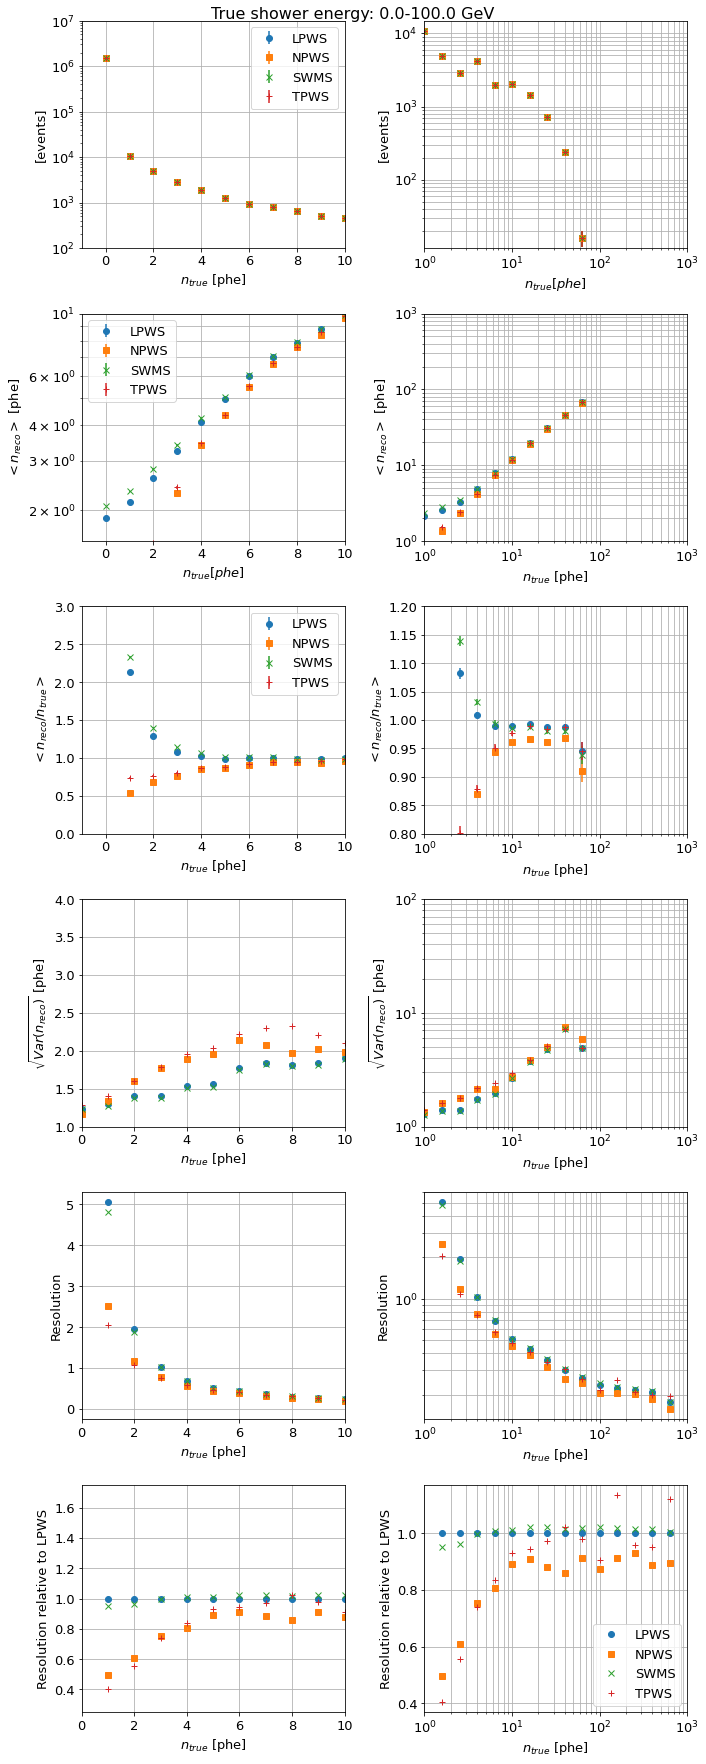

In [30]:
lowlevel_config_benchmark = lowlevel_configs[0]
dl1_data_benchmark = dl1_data_dict[lowlevel_config_benchmark]

fig, axes = plt.subplots(6, 2, figsize=(10, 25))
fig.suptitle('True shower energy: {0:.1f}-{1:.1f} GeV'.format(EMIN.to(u.GeV).value, EMAX.to(u.GeV).value), fontsize=16)
for i, lowlevel_config in enumerate(lowlevel_configs):
    dl1_data = dl1_data_dict[lowlevel_config]
    iax = 0
    
    # Linear X-axis
    xvalues = (dl1_data.reco_phe_stats['mean'][1][:-1])
    
    # Log X-axis    
    logxvalues = (dl1_data.reco_phe_stats_log['mean'][1][:-1])
        
    # Event count 
    axes[iax][0].errorbar(xvalues, \
                          dl1_data.reco_phe_stats['count'][0], \
                          yerr=np.sqrt(dl1_data.reco_phe_stats['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='major', axis='both')
    axes[iax][0].set_yscale('log')
    axes[iax][0].set_xlim(-1, 10)
    axes[iax][0].set_ylim(100, 1e7)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel('[events]')
    #axes[iax][0].legend(loc=0)


    axes[iax][1].errorbar(logxvalues, \
                          dl1_data.reco_phe_stats_log['count'][0], \
                          yerr=np.sqrt(dl1_data.reco_phe_stats_log['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_yscale('log')
    axes[iax][1].set_xlim(1, 1000)
    #axes[iax][1].set_ylim(1, 1000)
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlabel(r'$n_{true} [phe]$')
    axes[iax][1].set_ylabel('[events]')
                         
    iax += 1
        
    axes[iax][0].errorbar(xvalues, \
                          dl1_data.reco_phe_stats['mean'][0], \
                          yerr=dl1_data.reco_phe_stats['std'][0]/np.sqrt(dl1_data.reco_phe_stats['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_yscale('log')
    axes[iax][0].set_xlim(-1, 10)
    axes[iax][0].set_ylim(-1, 10)
    axes[iax][0].set_xlabel(r'$n_{true} [phe]$')
    axes[iax][0].set_ylabel(r'$<n_{reco}>$ [phe]')
    axes[iax][0].legend(loc=0)


    axes[iax][1].errorbar(logxvalues, \
                          dl1_data.reco_phe_stats_log['mean'][0], \
                          yerr=dl1_data.reco_phe_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_stats_log['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_yscale('log')
    axes[iax][1].set_xlim(1, 1000)
    axes[iax][1].set_ylim(1, 1000)
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel(r'$<n_{reco}>$ [phe]')
                         
    iax += 1

    axes[iax][0].errorbar(xvalues[1:], \
                          dl1_data.reco_phe_frac_stats['mean'][0][1:], \
                          yerr=dl1_data.reco_phe_frac_stats['std'][0][1:]/np.sqrt(dl1_data.reco_phe_frac_stats['count'][0][1:]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_xlim(-1, 10)
    axes[iax][0].set_ylim(0, 3)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel(r'$<n_{reco}/n_{true}>$')

    # Log X-axis    
    axes[iax][1].errorbar(logxvalues, \
                          dl1_data.reco_phe_frac_stats_log['mean'][0], \
                          yerr=dl1_data.reco_phe_frac_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_frac_stats_log['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_xlim(1, 1000)
    axes[iax][1].set_ylim(0.8, 1.2)
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel(r'$<n_{reco}/n_{true}>$')
                         
    iax += 1
    
    axes[iax][0].plot(xvalues, \
                    dl1_data.reco_phe_stats['std'][0], MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_xlim(0, 10)
    axes[iax][0].set_ylim(1, 4)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel(r'$\sqrt{Var(n_{reco})}$ [phe]')

    axes[iax][1].plot(logxvalues, \
                    dl1_data.reco_phe_stats_log['std'][0], MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_yscale('log')
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlim(1, 1000)
    axes[iax][1].set_ylim(1, 100)
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel(r'$\sqrt{Var(n_{reco})}$ [phe]')   
                         
    iax += 1
    axes[iax][0].plot(xvalues[1:], \
                    dl1_data.reco_phe_stats['std'][0][1:] / \
                    (dl1_data.reco_phe_stats['mean'][0][1:]-dl1_data.mean_phe_true0), \
                    MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_xlim(0, 10)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel('Resolution') #(r'$\sqrt{Var(n_{reco})} / (\bar{n}_{reco}-\bar{n}_{reco}(n_{true}=0))$')

    axes[iax][1].plot(logxvalues[1:], \
                    dl1_data.reco_phe_stats['std'][0][1:len(logxvalues)] / \
                    (dl1_data.reco_phe_stats['mean'][0][1:len(logxvalues)]-dl1_data.mean_phe_true0), \
                    MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_yscale('log')
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlim(1, 1000)
    #axes[iax][0].set_ylim(0, 3)
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel('Resolution')#r'$\sqrt{Var(n_{reco})} / (\bar{n}_{reco}-\bar{n}_{reco}(n_{true}=0))$')
    
    iax += 1
    axes[iax][0].plot(xvalues[1:], \
                      dl1_data.reco_phe_stats['std'][0][1:] / \
                      dl1_data_benchmark.reco_phe_stats['std'][0][1:] / \
                      (dl1_data.reco_phe_stats['mean'][0][1:]-dl1_data.mean_phe_true0) * \
                      (dl1_data_benchmark.reco_phe_stats['mean'][0][1:]-dl1_data_benchmark.mean_phe_true0), \
                      MARKER_STYLES[i%len(MARKER_STYLES)], label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_xlim(0, 10)
    axes[iax][0].set_ylim(0.25, 1.75)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel('Resolution relative to {0}'.format(lowlevel_config_benchmark.abbreviation))    

    axes[iax][1].plot(logxvalues[1:], \
                      dl1_data.reco_phe_stats['std'][0][1:len(logxvalues)] / \
                      dl1_data_benchmark.reco_phe_stats['std'][0][1:len(logxvalues)] / \
                      (dl1_data.reco_phe_stats['mean'][0][1:len(logxvalues)]-dl1_data.mean_phe_true0) * \
                      (dl1_data_benchmark.reco_phe_stats['mean'][0][1:len(logxvalues)]-dl1_data_benchmark.mean_phe_true0), \
                      MARKER_STYLES[i%len(MARKER_STYLES)], label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    #axes[iax][1].set_yscale('log')
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlim(1, 1000)
    #axes[iax][0].set_ylim(0, 3)
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel('Resolution relative to {0}'.format(lowlevel_config_benchmark.abbreviation))
    
axes[0][0].legend(loc=0)   
axes[2][0].legend(loc=0)
axes[5][1].legend(loc=0)
plt.tight_layout()    

## Distribution for specific-phe-number events

In [31]:
list_true_phes = [0, 3, 6, 10] #List of the true photoelectron numbers to draw the distribution of the reconstructed phe
mask_truephe = {}
true_phe_bins = np.linspace(-10, 30, 81)

for i, lowlevel_config in enumerate(lowlevel_configs):
    dl1_data = dl1_data_dict[lowlevel_config]    
    for tphe in list_true_phes:
        mask_truephe[tphe] = np.array(dl1_data.true_phe!=tphe)
        dl1_data.reco_phe_hists[tphe] = np.histogram(dl1_data.dl1_reco_phe, \
                                                     weights=[float(1-m) for m in mask_truephe[tphe]], \
                                                     bins=true_phe_bins)

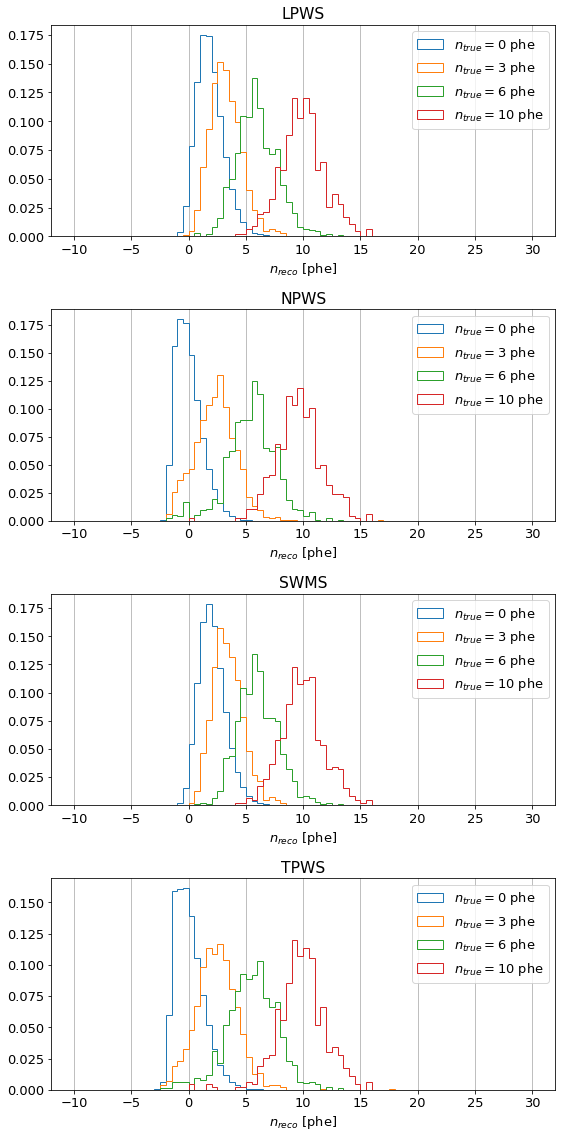

In [34]:
fig, axes = plt.subplots(len(lowlevel_configs), 1, figsize=(8, 4*len(lowlevel_configs)))
for i, image_extracter_config in enumerate(lowlevel_configs):
    dl1_data = dl1_data_dict[image_extracter_config]     
    for j, tphe in enumerate(list_true_phes):
        axes[i].hist(dl1_data.reco_phe_hists[tphe][1][:-1], \
                     dl1_data.reco_phe_hists[tphe][1], \
                     weights=dl1_data.reco_phe_hists[tphe][0]/sum(dl1_data.reco_phe_hists[tphe][0]), \
                     label=r'$n_{{true}}={{{0}}}$ phe'.format(tphe), histtype='step')#, alpha=0.2)
    axes[i].set_title(image_extracter_config.abbreviation)
    axes[i].grid(True, which='major', axis='x')
    axes[i].set_xlabel(r'$n_{reco}$ [phe]')
    axes[i].legend(loc=0)    
plt.tight_layout()  

## ROC Curve

In [ ]:
sig_phes = [3, 6, 10]
fig, axes = plt.subplots(len(sig_phes), 1, figsize=(10, 6*len(sig_phes)))

for i, sig_phe in enumerate(sig_phes):
    for j, lowlevel_config in enumerate(lowlevel_configs):
        dl1_data = dl1_data_dict[lowlevel_config] 
        xvals, yvals = dl1_data.get_roc_curve(sig_phe=sig_phe)
        axes[i].plot(xvals, yvals, label=lowlevel_config.abbreviation, ls=LINE_STYLES[j%len(LINE_STYLES)])
    axes[i].set_title(r'$n_{{true}}={0}$ phe'.format(sig_phe))
    axes[i].grid(True, which='major', axis='both')
    axes[i].set_yscale('log')
    axes[i].set_ylim(1e-3, 1)
    axes[i].set_xlabel('Signal acceptance')
    axes[i].set_ylabel('Background residual')
    axes[i].legend(loc=0)    
plt.tight_layout()  

# Separation power evaluation
Not working well yet

In [ ]:
#for i, lowlevel_config in enumerate(lowlevel_configs):
#    logger.info(lowlevel_config.name)
#    lowlevel_config.find_best_separation('error', [0,3])

In [ ]:
#for i, lowlevel_config in enumerate(lowlevel_configs):
#    logger.info(lowlevel_config.name)
#    lowlevel_config.find_best_separation('error', [0,6])

In [ ]:
#for i, lowlevel_config in enumerate(lowlevel_configs):
#    logger.info(lowlevel_config.name)
#    lowlevel_config.find_best_separation('error', [0,10])

# Hillas Parameters

In [ ]:
fig, axes = plt.subplots(len(HILLASES_OF_INTEREST), 1, figsize=(10, 6*len(HILLASES_OF_INTEREST)))

for i, param in enumerate(HILLASES_OF_INTEREST):
    for j, lowlevel_config in enumerate(lowlevel_configs):
        dl1_data = dl1_data_dict[lowlevel_config] 
        vals = dl1_data.parameter_value_dict[param]
        if j==0:
            hist_result = axes[i].hist(vals, lw=2, bins=100, histtype="step", label=lowlevel_config.abbreviation)
        else:
            axes[i].hist(vals, lw=2, bins=hist_result[1], histtype="step", label=lowlevel_config.abbreviation)
    #axes[i].set_title(param)
    axes[i].grid(True, which='major', axis='both')
    #axes[i].set_yscale('log')
    #axes[i].set_ylim(1e-3, 1)
    axes[i].set_xlabel(param)
    axes[i].set_ylabel('[events]')
    axes[i].legend(loc=0)    
plt.tight_layout()  

In [ ]:
plots = []
NCOLS = 3
NROWS = ceil(len(HILLASES_OF_INTEREST)/NCOLS)
for j, (lowlevel_config, real_lowlevel_config) in enumerate(zip(lowlevel_configs, real_lowlevel_configs)):
    #plot.append(plt.subplots(len(lowlevel_configs), len(HILLASES_OF_INTEREST), figsize=(10,6**len(HILLASES_OF_INTEREST))))#(6*len(lowlevel_configs), 6*len(HILLASES_OF_INTEREST))))
    plots.append(plt.subplots(NCOLS, NROWS, figsize=(6*NROWS, 10)))#(6*len(lowlevel_configs), 6*len(HILLASES_OF_INTEREST))))
    fig, axes = plots[-1]
    fig.suptitle(lowlevel_config.abbreviation)
    for i, param in enumerate(HILLASES_OF_INTEREST):
        # MC
        dl1_mc = dl1_data_dict[lowlevel_config] 
        vals_mc = dl1_mc.parameter_value_dict[param]
        hist_results = {}
        if not param in hist_results.keys():
            hist_results[param] = axes[int(i/NCOLS)][i%NCOLS].hist(vals_mc, lw=2, bins=100, histtype="step", label=dl1_mc.name, density=True)
        else:
            axes[int(i/NCOLS)][i%NCOLS].hist(vals_mc, lw=2, bins=hist_results[param][1], histtype="step", label=dl1_mc.name, density=True)
        # Real
        for run in real_runs:
            dl1_data = real_dl1_data_dict[real_lowlevel_config][run]
            mask_trigger = np.array(dl1_data.parameter_value_dict["intensity"])>20000
            vals = ma.masked_array(dl1_data.parameter_value_dict[param], mask=mask_trigger)
            axes[int(i/NCOLS)][i%NCOLS].hist(vals, lw=2, bins=hist_results[param][1], histtype="step", label='Run {0}'.format(run), density=True)
        #title = lowlevel_config.abbreviation
        #axes[int(i/NCOLS)][i%NCOLS].set_title(title)
        axes[int(i/NCOLS)][i%NCOLS].grid(True, which='major', axis='both')
        axes[int(i/NCOLS)][i%NCOLS].set_yscale('log')
        axes[int(i/NCOLS)][i%NCOLS].set_xscale('log')
        #axes[int(i/NCOLS)][i%NCOLS].set_ylim(1e-3, 1)
        #if j==len(lowlevel_configs)-1:
        axes[int(i/NCOLS)][i%NCOLS].set_xlabel(param)
        axes[int(i/NCOLS)][i%NCOLS].set_ylabel('[events]')
        if i==0:
            axes[int(i/NCOLS)][i%NCOLS].legend(loc=0)    
    plt.tight_layout() 